In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

from IPython.display import clear_output
import sys

### Creating config object (argparse workaround)

In [37]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [38]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [39]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [40]:
X, y = next(iter(dataloader))
X = X.numpy()
y = y.numpy()

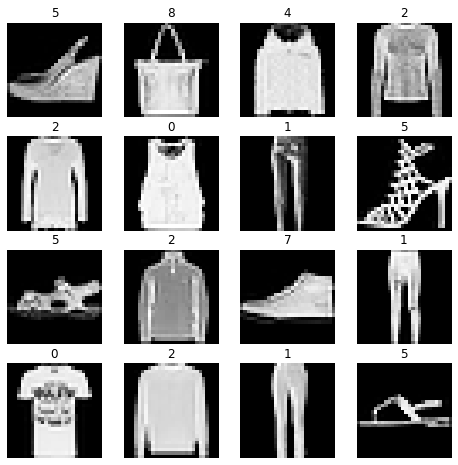

In [41]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [42]:
len(dataloader)

3750

In [43]:
for image, cat in dataloader:
    break

In [44]:
image.size()

torch.Size([16, 1, 28, 28])

In [45]:
28*28

784

### Create generator and discriminator

In [46]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [47]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [48]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [49]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [50]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
errorsD_x = []
errorsD_z = []
errorsG = []

def train(generator, discriminator, criterion, config, dataloader):
    input = Variable(torch.FloatTensor(config.batch_size, 28*28))
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.FloatTensor(config.batch_size))
    real_label = 1
    fake_label = 0
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
    N = len(dataloader)
    errorsD_x = []
    errorsD_z = []
    errorsG = []
    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
            ####### 
            # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
            #######
            discriminator.zero_grad()

            # real
            label.data.fill_(real_label)
            input_data = images.view(config.batch_size, -1)
            output = discriminator(input_data)
            errD_x = criterion(output, label.view(config.batch_size, 1))
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward()

            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output, label.view(config.batch_size, 1))
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward()

            optim_D.step()

            ####### 
            # Generator stage: maximize log(D(G(x))
            #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake)
            errG = criterion(output, label.view(config.batch_size, 1))
            ERRG[epoch] += errG.item()
            errG.backward()

            optim_G.step()

            if (iteration+1) % config.print_freq == 0:
                clear_output(True)
                errorsD_x.append(errD_x.item())
                errorsD_z.append(errD_z.item())
                errorsG.append(errG.item())
                print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                                iteration+1, 
                                                                                                errD_x.item(),
                                                                                                errD_z.item(), 
                                                                                                errG.item()))

    #             plot = True
    #             if plot:
                plt.figure(figsize = (12, 5))       
                plt.subplot(2, 2, 1)
                plt.plot(errorsD_x, label="discriminator's errors on real images")
                plt.xlabel('Epoches')
                plt.ylabel('Loss')
                plt.legend()


                plt.subplot(2, 2, 2)
                plt.plot(errorsD_z, label="discriminator's errors on fake images")
                plt.xlabel('Epoches')
                plt.ylabel('Loss')
                plt.legend()

                plt.subplot(2, 1, 2)
                plt.plot(errorsD_x, label = "generator's error")
                plt.xlabel('Epoches')
                plt.ylabel('Loss')
                plt.legend()

                plt.show()

Epoch:10 Iter: 3700 errD_x: 0.43 errD_z: 0.08 errG: 3.60


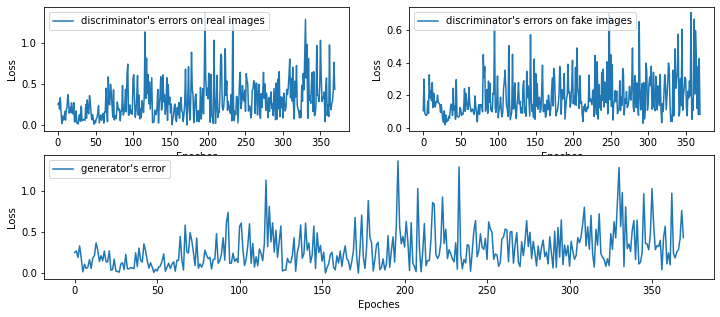

In [51]:
train(generator, discriminator, nn.BCELoss(), config, dataloader)


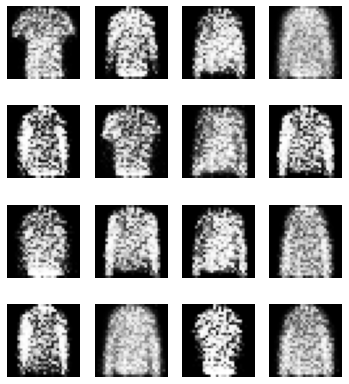

In [52]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Интерполяция

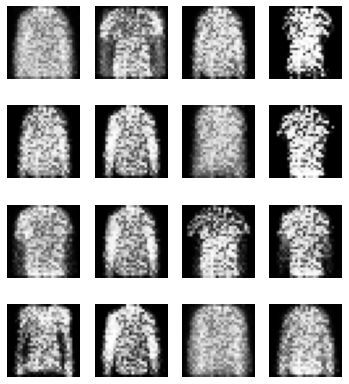

In [53]:
plt.figure(figsize=(6, 7))

with torch.no_grad():
    while True:
        noise.data.normal_(0, 1)
        noise_v1 = noise.clone()
        noise.data.normal_(0, 1)
        noise_v2 = noise.clone()
        eps = 1e-6
        norm = torch.norm( noise_v2 - noise_v1, p=2)
        if norm > eps:
            break
    v0 = noise_v1
    r = (noise_v2 - noise_v1) / norm
    fakes = []
    for t in np.linspace(0, norm, 100):
        noise_v = v0 + t * r
        fake = generator(noise_v)
        fakes.append( fake.detach().numpy().reshape(16, 28, 28) )
    result = np.mean(fakes, axis=0)
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(result[i], cmap=plt.cm.Greys_r)
        plt.axis('off')

### LSGAN

In [54]:
class LSGenerator(nn.Module):
    def __init__(self):
        super(LSGenerator, self).__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(config.noise_size, 256, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        ) 
    def forward(self, x):
        x = x.view(-1, 50, 1, 1)
        x = self.model(x)
        return x
    
class LSDiscriminator(nn.Module):
    def __init__(self):
        super(LSDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.linear = nn.Sequential(nn.Linear(2*2*512, 1), nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.model(x)
        x = x.view(-1, 2*2*512)
        return self.linear(x)

In [55]:
generatorLS = LSGenerator()
discriminatorLS =  LSDiscriminator()


Epoch:10 Iter: 3700 errD_x: 0.15 errD_z: 0.52 errG: 1.44


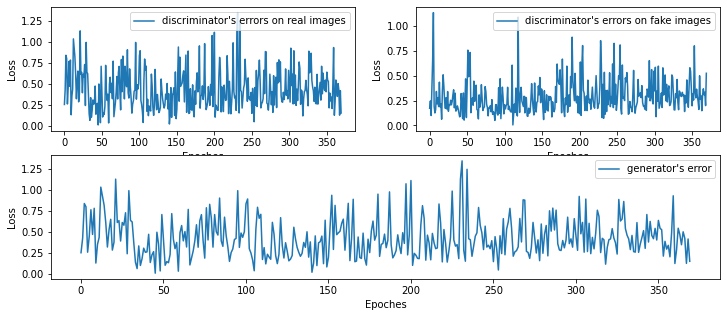

In [56]:
train(generator, discriminator, nn.BCELoss(), config, dataloader)


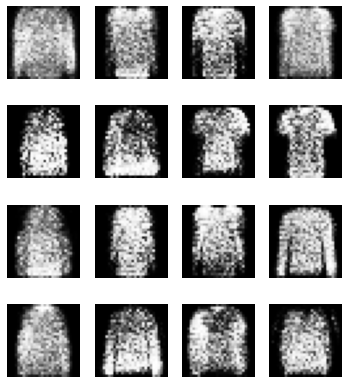

In [57]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

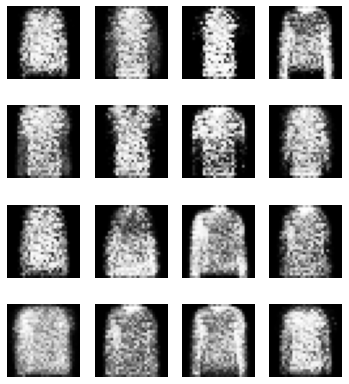

In [58]:
plt.figure(figsize=(6, 7))

with torch.no_grad():
    while True:
        noise.data.normal_(0, 1)
        noise_v1 = noise.clone()
        noise.data.normal_(0, 1)
        noise_v2 = noise.clone()
        eps = 1e-6
        norm = torch.norm( noise_v2 - noise_v1, p=2)
        if norm > eps:
            break
    v0 = noise_v1
    r = (noise_v2 - noise_v1) / norm
    fakes = []
    for t in np.linspace(0, norm, 100):
        noise_v = v0 + t * r
        fake = generator(noise_v)
        fakes.append( fake.detach().numpy().reshape(16, 28, 28) )
    result = np.mean(fakes, axis=0)
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(result[i], cmap=plt.cm.Greys_r)
        plt.axis('off')

In [59]:
class CGenerator(nn.Module):
    def __init__(self):
        super(CGenerator, self).__init__()
        self.model = nn.Sequential(
              nn.Linear(50 + 10, 200),
              nn.ReLU(inplace=True),
              nn.Linear(200, 28*28),
              nn.Sigmoid())
        self.emb = nn.Embedding(10, 10)
        
    def forward(self, x, labels):
        c = self.emb(labels)
        x = torch.cat([x,c], 1)
        return self.model(x).squeeze()
    
class CDiscriminator(nn.Module):
    def __init__(self):
        super(CDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
        self.embedding = nn.Embedding(10, 10)
        
    def forward(self, x, y):
        emb = self.embedding(y)
        x = torch.cat([x,emb], 1)
        return self.model(x)

In [60]:
generator = CGenerator()
discriminator = CDiscriminator()

Epoch:10 Iter: 3700 errD_x: 0.60 errD_z: 0.11 errG: 2.57


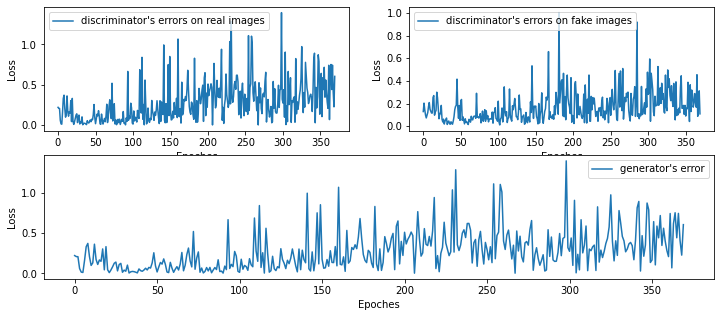

In [61]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
N = len(dataloader)
errorsD_x = []
errorsD_z = []
errorsG = []
criterion=nn.BCELoss()
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()

        labels = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size)))
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(config.batch_size, -1)
        output = discriminator(input_data, labels)
        errD_x = criterion(output, label.view(config.batch_size, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise, labels)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach(), labels)
        errD_z = criterion(output, label.view(config.batch_size, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake, labels)
        errG = criterion(output, label.view(config.batch_size, 1))
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            clear_output(True)
            errorsD_x.append(errD_x.item())
            errorsD_z.append(errD_z.item())
            errorsG.append(errG.item())
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

#             plot = True
#             if plot:
            plt.figure(figsize = (12, 5))       
            plt.subplot(2, 2, 1)
            plt.plot(errorsD_x, label="discriminator's errors on real images")
            plt.xlabel('Epoches')
            plt.ylabel('Loss')
            plt.legend()


            plt.subplot(2, 2, 2)
            plt.plot(errorsD_z, label="discriminator's errors on fake images")
            plt.xlabel('Epoches')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(2, 1, 2)
            plt.plot(errorsD_x, label = "generator's error")
            plt.xlabel('Epoches')
            plt.ylabel('Loss')
            plt.legend()

            plt.show()

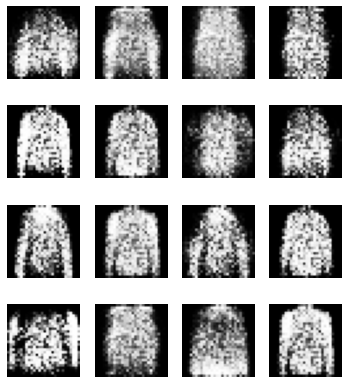

In [63]:
noise.data.normal_(0, 1)
labels = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size)))

fake = generator(noise, labels)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Кажется, для наилучшей сходимости лучше использовать GAN с добавлением условной метки во время обучения. Наилучшие результаты по лоссу показала LSGAN